#Perfoming Naive Bayes on Amazon Fine Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews : 568,454

Number of products : 74,258

Timespan : Oct 1999 - Oct 2012

Number of Attributes/Columns in data : 10

###Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

###Objective:

Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

##1. Reading Data

###1.1. Loading Data

The dataset is available in two forms

1. csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from nltk.stem.porter import PorterStemmer
import sklearn
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import BernoulliNB

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
#lists the content of your google drive
!ls "/content/drive/My Drive/datasets/amazon fine food"

database.sqlite


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/datasets/amazon fine food/database.sqlite') 

# filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
# for this analysis we are only taking 50000 data points considering our computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

##2. Exploratory Data Analysis

###2.1. Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

###Observation:-
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

##3. Preprocessing 

###3.1. Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [0]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [0]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)


{'a', 'll', 'shan', 'up', 're', 'isn', 'under', 'own', 'why', 'then', 'at', "you'd", 'itself', 'off', 'some', 'having', "didn't", 'weren', 'haven', 'other', 'ma', "shan't", 'that', 'o', 'while', "she's", "aren't", 'am', 'do', "needn't", 'the', "haven't", "don't", 'won', 'he', 'an', 'didn', 'being', "hadn't", 'of', 'nor', 'yours', 'all', 'again', 'more', 'y', 'most', 'very', 'herself', 'because', "you'll", 'whom', 'few', 'is', 'have', 'from', 'we', 'such', 's', "should've", 'their', 'about', "isn't", "won't", 't', 'will', 'ain', 'her', 'his', 'any', 'over', 'only', 'between', 'hers', 'wasn', 'yourselves', 'both', 'same', 'doesn', 'which', 'themselves', 'shouldn', 'too', 'theirs', 'doing', 'your', 'with', 'out', "weren't", 'been', "mightn't", "wouldn't", 'but', "shouldn't", "it's", 'by', 'ours', 'himself', 'how', 'be', 'you', 'where', 'aren', "doesn't", 'did', 'what', 'wouldn', 'yourself', 'him', 'should', 'those', 'further', 'no', 'its', "you've", 'before', 'each', 'our', 'if', 'hasn', 

In [0]:
# Combining all the above stundents 
from tqdm import tqdm

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 87773/87773 [02:14<00:00, 653.59it/s]


In [0]:
#after data suplication and preprocessing we are adding the CleanedText as a new attribute of our dataset
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
final.shape

(87773, 11)

In [0]:
#sorting the dataset by time so that we can later perform time-based splitting of the dataset into train and test
final = final.sort_values(by=['Time'], axis=0) 
score = final['Score'].values
text = final['CleanedText'].values

In [0]:
#splitting the dataset into train, test and cross validate 
x_train, x_test, y_train, y_test = train_test_split(text, score, test_size=0.3, shuffle=False)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)

In [0]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_cv.shape, y_cv.shape)

(43008,) (43008,)
(26332,) (26332,)
(18433,) (18433,)


In [0]:
print("Number of positive(1) and negative(0) datapoints in our train dataset")
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

Number of positive(1) and negative(0) datapoints in our train dataset


{0: 6359, 1: 36649}

In [0]:
print("Number of positive(1) and negative(0) datapoints in our test dataset")
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

Number of positive(1) and negative(0) datapoints in our test dataset


{0: 4557, 1: 21775}

In [0]:
print("Number of positive(1) and negative(0) datapoints in our cross validate dataset")
unique, counts = np.unique(y_cv, return_counts=True)
dict(zip(unique, counts))

Number of positive(1) and negative(0) datapoints in our cross validate dataset


{0: 3265, 1: 15168}

##4. Applying Bernoulli Naive Bayes

###4.1. on Bag of Words

In [0]:
#coveting text to vectors using BOW 
#will be coverting train, test and cross validate datasets seperately to overcome data leakage problem

count_vect = CountVectorizer() #in scikit-learn

#converting train data to vectors using BOW
bow_x_train = count_vect.fit_transform(x_train) 
bow_x_train.shape

(43008, 24426)

In [0]:
#converting test data to vectors using BOW
bow_x_test = count_vect.transform(x_test)
bow_x_test.shape

(26332, 24426)

In [0]:
#converting cross validate data to vectors using BOW
bow_x_cv = count_vect.transform(x_cv)
bow_x_cv.shape

(18433, 24426)

100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


0.009


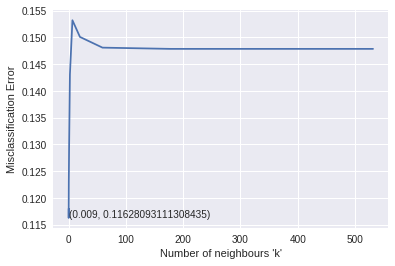

In [0]:
#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = BernoulliNB(alpha=k)
    scores = cross_val_score(bnb, bow_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()
    

In [0]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (0.009)

#initiate model
bnb = BernoulliNB(alpha = optimal_alpha)

#fit model
bnb.fit(bow_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(bow_x_test)

#calculating accuracy of model
train_acc = bnb.score(bow_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9331752232142857
Train Error:  0.0668247767857143
Test Accuracy:  0.8801458301686161
Test Error:  0.11985416983138386
_____________________________________________________________________________________________________


In [0]:
#feature selection

# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


like	 -->	-0.993329  
tast	 -->	-0.994179  
product	 -->	-1.227681  
one	 -->	-1.338243  
would	 -->	-1.425254  
tri	 -->	-1.458502  
good	 -->	-1.513395  
flavor	 -->	-1.522724  
buy	 -->	-1.606137  
get	 -->	-1.684352  
use	 -->	-1.738325  
dont	 -->	-1.742807  
even	 -->	-1.821278  
much	 -->	-1.880324  
order	 -->	-1.893816  
eat	 -->	-1.961913  
make	 -->	-1.986829  
love	 -->	-1.986829  
realli	 -->	-2.014738  
amazon	 -->	-2.028990  


Top 20 Important Features and their log probabilities For Positive Class :


like	 -->	-1.158691  
tast	 -->	-1.226573  
love	 -->	-1.237235  
good	 -->	-1.260061  
great	 -->	-1.300803  
flavor	 -->	-1.403495  
one	 -->	-1.446373  
tri	 -->	-1.524196  
use	 -->	-1.599095  
product	 -->	-1.615431  
get	 -->	-1.679768  
make	 -->	-1.680354  
buy	 -->	-1.927471  
time	 -->	-1.946782  
best	 -->	-1.961612  
would	 -->	-1.965500  
amazon	 -->	-1.967059  
realli	 -->	-1.973714

In [0]:
# evaluate precision
acc = precision_score(y_test, y_test_pred, pos_label = 1) 
print('\nThe Test Precision for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test Recall for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test F1-Score for alpha (%.3f) is %f' % (optimal_alpha, acc))


The Test Precision for alpha (0.009) is 0.913296

The Test Recall for alpha (0.009) is 0.944753

The Test F1-Score for alpha (0.009) is 0.928758


In [0]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(bow_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(bow_x_test)))

Train confusion matrix
[[ 4720  1639]
 [ 1235 35414]]
Test confusion matrix
[[ 2604  1953]
 [ 1203 20572]]


####Observation : 
1. Hyperparameter (alpha) = 0.009
2. Train Accuracy = 0.9331752232142857
3. Test Accuracy = 0.8801458301686161
4. Test Precision = 0.913296
5. Test Recall = 0.944753
6. F1-Score = 0.928758

###4.2. on TF-IDF

In [0]:
#coveting text to vectors using tf-idf 

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

#converting train data to vectors using tf-idf
tf_idf_x_train = tf_idf_vect.fit_transform(x_train)
tf_idf_x_train.shape

(43008, 674017)

In [0]:
#converting test data to vectors using tf-idf
tf_idf_x_test = tf_idf_vect.transform(x_test)
tf_idf_x_test.shape

(26332, 674017)

In [0]:
#converting cross validate data to vectors using tf-idf
tf_idf_x_cv = tf_idf_vect.transform(x_cv)
tf_idf_x_cv.shape

(18433, 674017)

100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


0.001


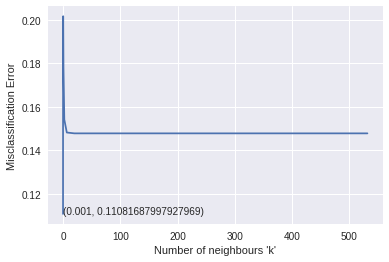

In [0]:
#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = BernoulliNB(alpha=k)
    scores = cross_val_score(bnb, tf_idf_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (0.001)

#initiate model
bnb = BernoulliNB(alpha = optimal_alpha)

#fit model
bnb.fit(tf_idf_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(tf_idf_x_test)

#calculating accuracy of model
train_acc = bnb.score(tf_idf_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9987444196428571
Train Error:  0.0012555803571429047
Test Accuracy:  0.8633981467416072
Test Error:  0.1366018532583928
_____________________________________________________________________________________________________


In [0]:
#feature selection

# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


like	 -->	-0.993330  
tast	 -->	-0.994180  
product	 -->	-1.227683  
one	 -->	-1.338246  
would	 -->	-1.425257  
tri	 -->	-1.458505  
good	 -->	-1.513398  
flavor	 -->	-1.522728  
buy	 -->	-1.606140  
get	 -->	-1.684356  
use	 -->	-1.738329  
dont	 -->	-1.742811  
even	 -->	-1.821283  
much	 -->	-1.880330  
order	 -->	-1.893822  
eat	 -->	-1.961920  
love	 -->	-1.986836  
make	 -->	-1.986836  
realli	 -->	-2.014745  
time	 -->	-2.028997  


Top 20 Important Features and their log probabilities For Positive Class :


like	 -->	-1.158691  
tast	 -->	-1.226573  
love	 -->	-1.237236  
good	 -->	-1.260061  
great	 -->	-1.300803  
flavor	 -->	-1.403495  
one	 -->	-1.446373  
tri	 -->	-1.524197  
use	 -->	-1.599096  
product	 -->	-1.615431  
get	 -->	-1.679769  
make	 -->	-1.680354  
buy	 -->	-1.927472  
time	 -->	-1.946784  
best	 -->	-1.961613  
would	 -->	-1.965501  
amazon	 -->	-1.967060  
realli	 -->	-1.973715  

In [0]:
# evaluate precision
acc = precision_score(y_test, y_test_pred, pos_label = 1) 
print('\nThe Test Precision for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test Recall for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test F1-Score for alpha (%.3f) is %f' % (optimal_alpha, acc))


The Test Precision for alpha (0.001) is 0.861881

The Test Recall for alpha (0.001) is 0.994122

The Test F1-Score for alpha (0.001) is 0.923290


In [0]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(tf_idf_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(tf_idf_x_test)))

Train confusion matrix
[[ 6309    50]
 [    4 36645]]
Test confusion matrix
[[ 1088  3469]
 [  128 21647]]


####Observation : 
1. Hyperparameter (alpha) = 0.001
2. Train Accuracy = 0.9987444196428571
3. Test Accuracy = 0.8633981467416072
4. Test Precision = 0.861881
5. Test Recall = 0.994122
6. F1-Score = 0.923290

##5. Applying Multinomial Naive Bayes

###5.1. on Bag of Words

100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


2.187


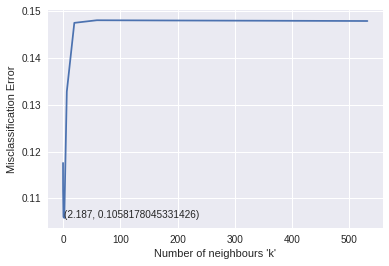

In [0]:
from sklearn.naive_bayes import MultinomialNB

#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = MultinomialNB(alpha=k)
    scores = cross_val_score(bnb, bow_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()
    

In [0]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (2.187)

#initiate model
bnb = MultinomialNB(alpha = optimal_alpha)

#fit model
bnb.fit(bow_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(bow_x_test)

#calculating accuracy of model
train_acc = bnb.score(bow_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9144577752976191
Train Error:  0.08554222470238093
Test Accuracy:  0.8888424730366095
Test Error:  0.11115752696339054
_____________________________________________________________________________________________________


In [0]:
# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


tast	 -->	-4.403103  
like	 -->	-4.461006  
product	 -->	-4.662734  
one	 -->	-4.885442  
flavor	 -->	-4.960417  
tri	 -->	-5.073391  
would	 -->	-5.081022  
good	 -->	-5.203079  
use	 -->	-5.302484  
food	 -->	-5.303759  
buy	 -->	-5.329614  
get	 -->	-5.369013  
coffe	 -->	-5.369013  
order	 -->	-5.450579  
dont	 -->	-5.473754  
tea	 -->	-5.481346  
dog	 -->	-5.492073  
even	 -->	-5.524165  
eat	 -->	-5.548317  
much	 -->	-5.580613  


Top 20 Important Features and their log probabilities For Positive Class :


like	 -->	-4.432665  
tast	 -->	-4.562481  
good	 -->	-4.652056  
flavor	 -->	-4.687535  
love	 -->	-4.692107  
great	 -->	-4.757440  
one	 -->	-4.798893  
tea	 -->	-4.857972  
use	 -->	-4.902497  
tri	 -->	-4.938976  
product	 -->	-4.962320  
food	 -->	-5.081653  
get	 -->	-5.101583  
make	 -->	-5.101814  
coffe	 -->	-5.135393  
eat	 -->	-5.348350  
dog	 -->	-5.357817  
would	 -->	-5.409829  
buy	 --

In [0]:
# evaluate precision
acc = precision_score(y_test, y_test_pred, pos_label = 1) 
print('\nThe Test Precision for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test Recall for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test F1-Score alpha (%.3f) is %f' % (optimal_alpha, acc))


The Test Precision for alpha (2.187) is 0.897436

The Test Recall for alpha (2.187) is 0.977268

The Test F1-Score alpha (2.187) is 0.935652


In [0]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(bow_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(bow_x_test)))

Train confusion matrix
[[ 3463  2896]
 [  783 35866]]
Test confusion matrix
[[ 2125  2432]
 [  495 21280]]


####Observation : 
1. Hyperparameter (alpha) = 2.187
2. Train Accuracy =0.9144577752976191
3. Test Accuracy = 0.8888424730366095
4. Test Precision = 0.897436
5. Test Recall = 0.977268
6. F1-Score = 0.935652

###5.2. on TF-IDF

100%|██████████| 13/13 [00:23<00:00,  1.78s/it]


0.081


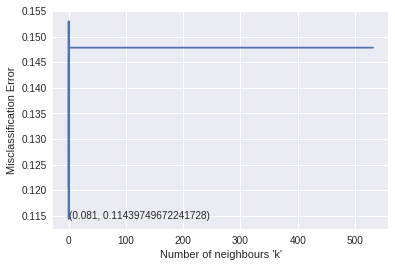

In [0]:
#taking alpha values from 10^-3 to 10^3
alpha_values = []
i = 0.001
while(i<=1000):
    alpha_values.append(np.round(i,3))
    i *= 3
    
cv_scores = [] #list to keep cross validate score
for k in tqdm(alpha_values):
    bnb = MultinomialNB(alpha=k)
    scores = cross_val_score(bnb, tf_idf_x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1) #cv = 10 to perform 10 fold cross validation 
    cv_scores.append(scores.mean())

#calculating Mssclassification error    
error = [1 - x for x in cv_scores]

#determing optimal alpha with least missclassification error value
optimal_alpha = alpha_values[error.index(min(error))]
print(optimal_alpha)

#graph between missclassification error and hyperparameter values 
plt.plot(alpha_values, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
#applying Bernoulli Naive Bayes on the optimal alpha calculated (0.081)

#initiate model
bnb = MultinomialNB(alpha = optimal_alpha)

#fit model
bnb.fit(tf_idf_x_train, y_train)

#predicting values for test data
y_test_pred =  bnb.predict(tf_idf_x_test)

#calculating accuracy of model
train_acc = bnb.score(tf_idf_x_train, y_train) #train accuracy
train_error = 1 - train_acc #train error
test_acc = accuracy_score(y_test, y_test_pred) #test accuracy
test_error = 1 - test_acc #test error

print("_" * 101)
print("Training Accuracy: ", train_acc)
print("Train Error: ", train_error)
print("Test Accuracy: ", test_acc)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9918852306547619
Train Error:  0.008114769345238138
Test Accuracy:  0.8433085219504785
Test Error:  0.15669147804952155
_____________________________________________________________________________________________________


In [0]:
# Now we can find log probabilities of different features for both the classes
class_features = bnb.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


tast	 -->	-6.706301  
like	 -->	-6.832726  
product	 -->	-6.888743  
flavor	 -->	-7.190229  
would	 -->	-7.191447  
one	 -->	-7.211831  
coffe	 -->	-7.227719  
tri	 -->	-7.322998  
buy	 -->	-7.351409  
order	 -->	-7.380114  
box	 -->	-7.474927  
good	 -->	-7.495073  
tea	 -->	-7.511908  
dont	 -->	-7.515440  
dog	 -->	-7.517353  
food	 -->	-7.524783  
get	 -->	-7.556695  
even	 -->	-7.600037  
use	 -->	-7.605432  
disappoint	 -->	-7.618333  


Top 20 Important Features and their log probabilities For Positive Class :


love	 -->	-6.343956  
tea	 -->	-6.366774  
great	 -->	-6.367763  
like	 -->	-6.390321  
good	 -->	-6.412959  
tast	 -->	-6.425736  
flavor	 -->	-6.478522  
coffe	 -->	-6.562965  
product	 -->	-6.656564  
one	 -->	-6.663039  
use	 -->	-6.693179  
tri	 -->	-6.741379  
dog	 -->	-6.824744  
make	 -->	-6.826880  
food	 -->	-6.829414  
get	 -->	-6.858564  
best	 -->	-6.918483  
price	 -->	-6.972441  


In [0]:
# evaluate precision
acc = precision_score(y_test, y_test_pred, pos_label = 1) 
print('\nThe Test Precision for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test Recall for alpha (%.3f) is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(y_test, y_test_pred, pos_label = 1)
print('\nThe Test F1-Score for alpha (%.3f) is %f' % (optimal_alpha, acc))


The Test Precision for alpha (0.081) is 0.840964

The Test Recall for alpha (0.081) is 0.999541

The Test F1-Score for alpha (0.081) is 0.913421


In [0]:
#evaluating confusion matrix for train and test
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, bnb.predict(tf_idf_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, bnb.predict(tf_idf_x_test)))

Train confusion matrix
[[ 6028   331]
 [   18 36631]]
Test confusion matrix
[[  441  4116]
 [   10 21765]]


####Observation : 
1. Hyperparameter (alpha) = 0.081
2. Train Accuracy = 0.9918852306547619
3. Test Accuracy = 0.8433085219504785
4. Test Precision = 0.840964
5. Test Recall = 0.999541
6. F1-Score = 0.913421

##6. Conclusion


In [0]:
!sudo pip3 install PTable

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Hyperparameter (alpha)", "Train Accuracy", "Test Accuracy", "Test Precision","Test Recall","F1-Score"]

x.add_row(["BOW (bernoulliNB)", 0.009, 0.9331752232142857, 0.8801458301686161, 0.913296, 0.944753, 0.928758])
x.add_row(["TF-IDF (bernoulliNB)", 0.001, 0.9987444196428571, 0.8633981467416072, 0.861881, 0.994122, 0.923290])
x.add_row(["BOW (MultinomialNB)", 2.187, 0.9144577752976191, 0.8888424730366095, 0.897436, 0.977268, 0.935652])
x.add_row(["TF-IDF (MultinomialNB)", 0.081, 0.9918852306547619, 0.8433085219504785, 0.840964, 0.999541, 0.913421])

print(x)

+------------------------+------------------------+--------------------+--------------------+----------------+-------------+----------+
|         Model          | Hyperparameter (alpha) |   Train Accuracy   |   Test Accuracy    | Test Precision | Test Recall | F1-Score |
+------------------------+------------------------+--------------------+--------------------+----------------+-------------+----------+
|   BOW (bernoulliNB)    |         0.009          | 0.9331752232142857 | 0.8801458301686161 |    0.913296    |   0.944753  | 0.928758 |
|  TF-IDF (bernoulliNB)  |         0.001          | 0.9987444196428571 | 0.8633981467416072 |    0.861881    |   0.994122  | 0.92329  |
|  BOW (MultinomialNB)   |         2.187          | 0.9144577752976191 | 0.8888424730366095 |    0.897436    |   0.977268  | 0.935652 |
| TF-IDF (MultinomialNB) |         0.081          | 0.9918852306547619 | 0.8433085219504785 |    0.840964    |   0.999541  | 0.913421 |
+------------------------+----------------------

After the analysis of 50000 data points we conclude that the best model is when we apply **Multinomial Naive Bayes on BOW** with

**Hyperparameter (K) = 2.187**

**Training Accuracy = 91.44577752976191%**

**Test Accuracy = 88.88424730366095%**